In [43]:
import os
import shutil
import time
import pandas as pd
import rasterio as rio
from ast import literal_eval
from matplotlib import pyplot as plt

Functions

In [44]:
def literal_return(val):
    """
    Return literal value if possible
    Args:
        val: any
    Returns: any
    """
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return val

In [45]:
def plot_sat(path):
    """
    Plot satellite image with optional geodataframe overlay
    Args:
        path: str
    """
    f, ax = plt.subplots(1,figsize=(3, 3))
    f.tight_layout()

    r = rio.open(path)
    r = r.read()
    r = r.transpose((1,2,0,))

    ax.imshow(r, origin='lower')

In [46]:
# get center of raster
def get_center(raster_path):
    """
    Get center of raster
    Args:
        raster_path: str
    Returns: tuple of ints
    """
    r = rio.open(raster_path)
    x = r.width//2
    y = r.height//2
    return x, y

In [47]:
# crop raster at center
def crop_raster(raster_path, size, plot=True, coords_only=False):
    """
    Crop raster at center
    Args:
        raster_path: str
        size: int
        plot: bool
    Returns: (np.array, list of ints)
    """
    r = rio.open(raster_path)
    r = r.read()
    r = r.transpose((1,2,0,))

    x, y = get_center(raster_path)

    x1 = x - size//2
    x2 = x + size//2
    y1 = y - size//2
    y2 = y + size//2

    r = r[x1:x2, y1:y2, :]

    if plot:
        f, ax = plt.subplots(1,figsize=(3, 3))
        f.tight_layout()
        ax.imshow(r, origin='lower')
        
    if coords_only:
        return x1, x2, y1, y2
    else:
        return r, (x1, x2, y1, y2)

In [48]:
def plot_pins(ras, raster_pins, coords):
    """
    Plot pins
    Args:
        ras: np.array
        raster_pins: lst of tuples
        coords: lst of ints
    """
    f, ax = plt.subplots(1,figsize=(3, 3))
    f.tight_layout()
    ax.imshow(ras, origin='lower')
    for pin in raster_pins:
        ax.scatter(pin[0] - coords[0], pin[1] - coords[2], c='r', s=5)

In [49]:
def filter_pins(lst, coords):
    """
    Filter pins within coordinates
    Args:
        lst: lst of tuples
        coords: lst of floats
    Returns: list of tuples
    """
    return list(filter(lambda x: coords[0] <= x[0] <= coords[1] \
                                 and coords[2] <= x[1] <= coords[3], lst))

In [50]:
def relative_coords(lst, coords):
    """
    Get relative coordinates
    Args:
        lst: lst
        coords: lst of tuples
    Returns: list of tuples
    """
    return list(map(lambda x: (x[0] - coords[0], x[1] - coords[2]), lst))

In [51]:
def raster_profile(raster_path):
    """
    Get raster profile
    Args:
        raster_path: str 
    Returns: dict
    """
    r = rio.open(raster_path)
    return r.profile

In [52]:
def filter_idx(lst, coords):
    """
    Filter pin idx within coordinates
    Args:
        lst: lst of tuples
        coords: lst of floats
    Returns: list of ints
    """
    return [i for i, x in enumerate(lst) for _ in coords if
           (coords[0] <= x[0] <= coords[1]) and (coords[2] <= x[1] <= coords[3])]

In [53]:
def filter_building_counts(lst, idx):
    """
    Filter building counts
    Args:
        lst: lst of tuples
        idx: lst of ints
    Returns: lst of ints
    """
    try:
        return [lst[j] for j in idx]
    except IndexError:
        return 0

# Main

Constants

In [75]:
KW = 'PAN'
csv = f"building_{KW}-random.csv"

In [76]:
# load csv
df = pd.read_csv(csv, converters={'0': literal_return, '1': literal_return, '2': literal_return})
sample_raster = df['0'][0]

In [77]:
# '0' is raster path
# '1' is list of tuples of pins
# '2' is list of building counts
df.columns

Index(['Unnamed: 0', '0', '1', '2'], dtype='object')

In [78]:
df

,Unnamed: 0,0,1,2
0,0,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(748.8823172379905, 85.26946246717718), (705....","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
1,1,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(748.8823172379905, 85.26946246717718), (705....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(748.8823172379905, 85.26946246717718), (705....","[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
3,3,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(748.8823172379905, 85.26946246717718), (705....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(748.8823172379905, 85.26946246717718), (705....","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
495,495,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(748.8823172379905, 85.26946246717718), (705....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
496,496,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(748.8823172379905, 85.26946246717718), (705....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
497,497,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(748.8823172379905, 85.26946246717718), (705....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
498,498,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(748.8823172379905, 85.26946246717718), (705....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


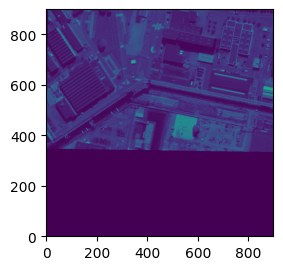

In [79]:
rastr = plot_sat(sample_raster)

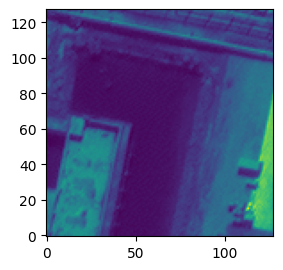

In [80]:
rastr, crds = crop_raster(sample_raster, 128)

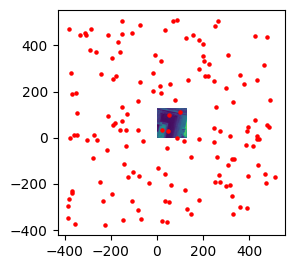

In [81]:
plot_pins(rastr, df['1'][0], crds)

In [82]:
start = time.time()

# initialize columns
df['coor'] = None
df['pins'] = None
df['idx'] = None
df['counts'] = None

# # column 'coor' is crop coordinates
df['coor'] = df['0'].apply(lambda x: crop_raster(x, 128, False, coords_only=True))
for i, _ in enumerate(df['coor']):
    # column 'pins' are pin coordinates adjusted to crop coordinates
    df.at[i, 'pins'] = relative_coords(filter_pins(df['1'][i], df['coor'][i]), df['coor'][i])
    # column 'idx' is idx of pins within crop coordinates
    df.at[i, 'idx'] = list(set(filter_idx(df['1'][i], df['coor'][i])))
    
for i, _ in enumerate(df['idx']):
    # column 'counts' is building counts within crop coordinates
    df.at[i, 'counts'] = filter_building_counts(df['2'][i], df['idx'][i])

# remove rows with no building counts
df = df[df['counts'] != 0]
# remove rows with empty list of pins
df = df[df['pins'].map(len) > 0]
df.drop(columns=['1', '2', 'coor', 'idx'], inplace=True)
print(f"--- {time.time() - start} seconds ---")

--- 1.6657130718231201 seconds ---


In [83]:
df

,Unnamed: 0,0,pins,counts
0,0,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(53.53470206885356, 96.66747440941663), (100....","[1, 0, 1, 0]"
1,1,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(53.53470206885356, 96.66747440941663), (100....","[0, 0, 0, 0]"
2,2,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(53.53470206885356, 96.66747440941663), (100....","[0, 2, 0, 0]"
3,3,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(53.53470206885356, 96.66747440941663), (100....","[0, 0, 0, 0]"
4,4,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(53.53470206885356, 96.66747440941663), (100....","[0, 0, 0, 0]"
...,...,...,...,...
495,495,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(53.53470206885356, 96.66747440941663), (100....","[1, 0, 1, 0]"
496,496,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(53.53470206885356, 96.66747440941663), (100....","[0, 0, 0, 0]"
497,497,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(53.53470206885356, 96.66747440941663), (100....","[0, 0, 0, 0]"
498,498,../data/AOI_11_Rotterdam/processed/PAN/SN6_Tra...,"[(53.53470206885356, 96.66747440941663), (100....","[0, 0, 0, 0]"


In [84]:
# save raster
type_ = 'cropped-random'
for rasterpath in df['0']:
    ras, _ = crop_raster(rasterpath, 128, False)
    profile = raster_profile(rasterpath)
    profile.update(width=ras.shape[0], height=ras.shape[1])
    save_dir = f"../data/AOI_11_Rotterdam/processed/{type_}/{KW}/"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fname = os.path.basename(rasterpath)
    with rio.open(f"{os.path.join(save_dir, fname)}", 'w', **profile) as dst:
        dst.write(ras.transpose(2, 0, 1))

In [85]:
# count list of files in save_dir
len(os.listdir(save_dir))

500

In [86]:
df.to_csv(f"../data/AOI_11_Rotterdam/processed/{type_}/building_{type_}_{KW}.csv", index=False)

In [72]:
# move images from PAN save_dir if not in PS-RGBNIR df
save_dir = f"../data/AOI_11_Rotterdam/processed/{type_}/PAN/"
for file in os.listdir(save_dir):
    # print(os.path.basename(file).split('_tile_')[1])
    if os.path.basename(file).split('_tile_')[1] not in [x.split('_tile_')[1] for x in df['0'].map(os.path.basename).tolist()]:
        # move to different directory     
        if not os.path.exists(f"../data/AOI_11_Rotterdam/processed/{type_}/unused/PAN/"):
            os.makedirs(f"../data/AOI_11_Rotterdam/processed/{type_}/unused/PAN/")
        shutil.move(os.path.join(save_dir, file), f"../data/AOI_11_Rotterdam/processed/{type_}/unused/PAN/")

In [87]:
# remove rows from PAN df if not in PS-RGBNIR df
pan_df = pd.read_csv(f"../data/AOI_11_Rotterdam/processed/{type_}/building_{type_}_PAN.csv", 
                     converters={'0': literal_return, '1': literal_return, '2': literal_return})

psrgb_df = pd.read_csv(f"../data/AOI_11_Rotterdam/processed/{type_}/building_{type_}_PS-RGBNIR.csv", 
                     converters={'0': literal_return, '1': literal_return, '2': literal_return})

pan_df = pan_df[pan_df['0'].apply(lambda x: os.path.basename(x).split('_tile_')[1]).isin(psrgb_df['0'].apply(lambda x: os.path.basename(x).split('_tile_')[1]))]
pan_df.to_csv(f"../data/AOI_11_Rotterdam/processed/{type_}/building_{type_}_PAN.csv", index=False)

In [88]:
pan_df.shape

(2748, 4)

In [89]:
psrgb_df.shape

(2748, 4)